In [45]:
# implementation of a character-based RNN to generate sonnets
import numpy as np
import random
import string
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.layers import SimpleRNN,LSTM,Bidirectional
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping

In [46]:
def preprocess(filename="shakespeare.txt", seq_length=40, step=5):
    '''
    returns semi-redundant sequences their outputs 
    seq_length: number of characters in each sequence
    step: gets every [step] sequence  
    '''

    print(seq_length)
    
    # puts all data into text string  
    file = open(filename, "r")
    text = ""
    for line in file:
        line = line.lstrip(' ').rstrip(' ')
        if line != '\n' and not line[0].isdigit():
            line.translate(str.maketrans('', '', string.punctuation))
            text += line.lower()

    # make char to index and index to char dictionary 
    characters = sorted(list(set(text)))
    char_indices_dict = dict((c, i) for i, c in enumerate(characters))
    indices_char_dict = dict((i, c) for i, c in enumerate(characters))
    #print(char_indices_dict)

    # makes every [step] char sequences of length seq_length and their outputs
    sequences = []
    next_chars = [] # next char that seq in sequences generates
    #print(repr(text[len(text) - 200:]))
    for i in range(0, len(text) - seq_length, step):
        #print(i, seq, text[i : i + seq_length])
        sequences.append(text[i : i + seq_length])
        next_chars.append(text[i + seq_length])

    # put sequences and outputs into np array
    x = np.zeros((len(sequences), seq_length, len(characters)))
    y = np.zeros((len(sequences), len(characters)), dtype=np.bool)
    for i, sequence in enumerate(sequences):
        for t, char in enumerate(sequence):
            x[i, t, char_indices_dict[char]] = 1
        y[i, char_indices_dict[next_chars[i]]] = 1

    return x, y, sequences, indices_char_dict, char_indices_dict, text

In [47]:
# using rnn to build model
def make_model(temperature=1.0,model_choice='rnn'):
    model = Sequential()
    if model_choice=='rnn':
        model.add(SimpleRNN(100))
    elif model_choice=='lstm':
        model.add(LSTM(100))
    elif model_choice=='bi_lstm':
        model.add(Bidirectional(LSTM(100)))
    # add temperature (controls variance)
    model.add(Lambda(lambda x: x / temperature))
    model.add(Dense(len(indices_char_dict), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

## get data

In [48]:
seq_length = 10
x, y, sequences, indices_char_dict, char_indices_dict, text = preprocess(seq_length=seq_length)

10


## RNN

In [ ]:
# model summary for RNN
print('model summary for rnn \n')
rnn_model=make_model(0.2,'rnn')
rnn_model.build(x.shape)
rnn_model.summary()

In [ ]:
# training for RNN

earlyStopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto')
rnn_history=rnn_model.fit(x, y, epochs=50, verbose=1, callbacks=[earlyStopping])
rnn_model.save('rnn.h5')

## LSTM

In [ ]:
# model summary for lstm
print('model summary for lstm \n')
lstm_model=make_model(0.2,'lstm')
lstm_model.build(x.shape)
lstm_model.summary()

In [ ]:
#  training for LSTM

earlyStopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto')
lstm_history=lstm_model.fit(x, y, epochs=50, verbose=1, callbacks=[earlyStopping])
lstm_model.save('lstm.h5')

## Bi-LSTM

In [ ]:
# model summary for bi_lstm
print('model summary for bi_lstm \n')
bi_lstm_model=make_model(0.2,'bi_lstm')
bi_lstm_model.build(x.shape)
bi_lstm_model.summary()

In [ ]:
#  training for bi-LSTM

earlyStopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto')
bi_lstm_history=bi_lstm_model.fit(x, y, epochs=50, verbose=1, callbacks=[earlyStopping])
bi_lstm_model.save('bi_lstm.h5')

## Momentum LSTM

In [5]:
import torch
import torch.jit as jit
from torch.nn import Parameter
from torch.nn import functional as F

import math
import tqdm

In [18]:
# https://github.com/minhtannguyen/MomentumRNN/blob/master/mnist-timit/momentumnet.py
class MomentumLSTMCell(torch.nn.Module):

    def __init__(self, input_size, hidden_size, mu=0.9, epsilon=0.1, bias=True, fg_init=1.0):
        super(MomentumLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.fg_init = fg_init
        self.x2h = torch.nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = torch.nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        
        # for momentumnet
        self.mu = mu
        self.epsilon = epsilon
        
        #self.reset_parameters(hidden_size)

    def reset_parameters(self, hidden_size):
        torch.nn.init.orthogonal_(self.x2h.weight)
        torch.nn.init.eye_(self.h2h.weight)
        torch.nn.init.zeros_(self.x2h.bias)
        self.x2h.bias.data[hidden_size:(2 * hidden_size)].fill_(self.fg_init) 
        torch.nn.init.zeros_(self.h2h.bias)
        self.h2h.bias.data[hidden_size:(2 * hidden_size)].fill_(self.fg_init)
    
    def forward(self, x, hidden, v):
        
        hx, cx = hidden
        
        x = x.view(-1, x.size(1))
        v = v.view(-1, v.size(1))
        
        vy = self.mu * v + self.epsilon * self.x2h(x)
        
        gates = vy + self.h2h(hx)
        
        # gates = gates.squeeze()
        
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)
        
        cy = torch.mul(cx, forgetgate) +  torch.mul(ingate, cellgate)        

        hy = torch.mul(outgate, F.tanh(cy))
        
        return hy, (hy, cy), vy

    
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, mu=0.9, epsilon=0.1, n_classes=38):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = MomentumLSTMCell(input_size, hidden_size, mu=mu, epsilon=epsilon)
        self.lin = torch.nn.Linear(hidden_size, n_classes)
        self.loss_func = torch.nn.CrossEntropyLoss()
        
    def forward(self, inputs):
        v = torch.zeros((inputs.size(0), 4 * self.hidden_size))
        state = (torch.zeros((inputs.size(0), self.hidden_size)),
                     torch.zeros((inputs.size(0), self.hidden_size)))
        
        iter_indx = 0
        for _input in torch.unbind(inputs, dim=1):
            # print(v.shape)
            iter_indx = iter_indx + 1
            out_rnn, state, v = self.rnn(_input, state, v)
            
        return self.lin(out_rnn)
    
    def loss(self, logits, y):
        return self.loss_func(logits, y)
    
    def correct(self, logits, y):
        return torch.eq(torch.argmax(logits, dim=1), y).float().sum()

In [19]:
## momentum LSTM
model = Model(input_size=38, hidden_size=100)
model

Model(
  (rnn): MomentumLSTMCell(
    (x2h): Linear(in_features=38, out_features=400, bias=True)
    (h2h): Linear(in_features=100, out_features=400, bias=True)
  )
  (lin): Linear(in_features=100, out_features=38, bias=True)
  (loss_func): CrossEntropyLoss()
)

In [43]:
num_param = 0
for parameter in model.parameters():
    num_param += parameter.numel()
print('Num parameter:', num_param)

Num parameter: 59838


In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.02, alpha=0.9)
# optimizer = torch.optim.SGD(model.parameters(), lr=2)
momLSTM_history = {'loss': [], 'acc': []}

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

batch_size = 32 # same as the default batch size used by keras
for epoch in range(50):
    permutation = torch.randperm(x.shape[0]) # get random permutataion of data in each epoch
    
    for i in tqdm.tqdm(range(0, len(x), batch_size), desc='Epoch: {}'.format(epoch)):
        optimizer.zero_grad()
        
        # get batch data
        indices = permutation[i:i+batch_size]
        xx, yy = torch.tensor(x[indices]).float(), torch.tensor(y[indices]).float()
        yy = yy.argmax(dim=1)

        logits = model(xx)
        loss = model.loss(logits, yy)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
    
    lr_scheduler.step()
        
    with torch.no_grad():
        logits = model(torch.tensor(x).float())
        loss = model.loss(logits, torch.tensor(y).float().argmax(1)).item()
        correct = model.correct(logits, torch.tensor(y).float().argmax(1)).item()
    
        momLSTM_history['loss'].append(loss)
        momLSTM_history['acc'].append(correct/len(y))
        print("Epoch: {} -- Loss: {:.4f} -- Acc: {:.4f}" .format(epoch, loss, correct/len(y)))
    

Epoch: 0:   0%|          | 0/586 [00:00<?, ?it/s]/home/zliangak/.conda/envs/dl36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/zliangak/.conda/envs/dl36/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
Epoch: 0:  17%|█▋        | 102/586 [00:46<01:04,  7.47it/s]

In [23]:
torch.save(model.state_dict(), './mLSTM_{}.h5'.format(seq_length))

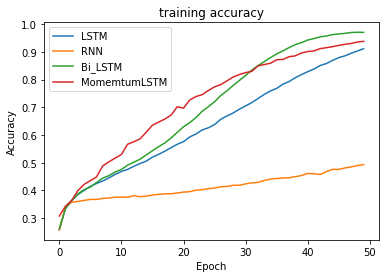

In [21]:
import matplotlib.pyplot as plt
# plot accuracy
plt.plot(lstm_history.history['acc'])
plt.plot(rnn_history.history['acc'])
plt.plot(bi_lstm_history.history['acc'])
plt.plot(momLSTM_history['acc'])
plt.title('training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'RNN','Bi_LSTM', 'MomemtumLSTM'], loc='upper left')
plt.show()

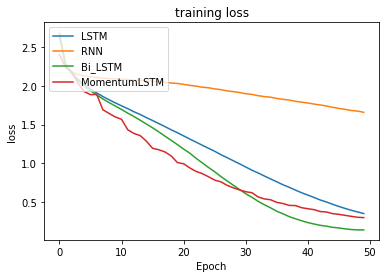

In [22]:

# plot loss
plt.plot(lstm_history.history['loss'])
plt.plot(rnn_history.history['loss'])
plt.plot(bi_lstm_history.history['loss'])
plt.plot(momLSTM_history['loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'RNN','Bi_LSTM', 'MomentumLSTM'], loc='upper left')
plt.show()

In [28]:

def generate_sonnet(model_choice='rnn'):

    if model_choice=='rnn':
        model = load_model('rnn.h5')
    elif model_choice=='lstm':
        model = load_model('lstm.h5')
    elif model_choice=='bi_lstm':
        model = load_model('bi_lstm.h5')
    sonnet = []
    
    seq = "shall i compare thee to a summer's day?\n"
    sonnet.append(seq)
    for _ in range(13):
        line = ""
        for i in range(40):
            x = np.zeros((1, len(seq), len(indices_char_dict)))
            for t, index in enumerate(seq):
                x[0, t, char_indices_dict[index]] = 1.

            prediction = model.predict(x)[0]
            index = np.argmax(prediction)
            char = indices_char_dict[index]
            line += char
            seq = seq[1:] + char

        sonnet.append(line)
    return sonnet

In [ ]:
sonnet=generate_sonnet('rnn')
print('sonnet by rnn: \n')
for line in sonnet:
    print(line)

In [ ]:
sonnet=generate_sonnet('lstm')

print('sonnet by lstm: \n')
for line in sonnet:
    print(line)

In [ ]:

sonnet=generate_sonnet('bi_lstm')

print('sonnet by bi_lstm: \n')
for line in sonnet:
    print(line)